# VarAnneal tutorial

VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.

VA uses numerical optimization to estimate path-space statistics given by high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  Optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed using automatic differentiation.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

In [1]:
import numpy as np
from scipy import interpolate
from varanneal import va_ode
import pickle
import os, time

In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors

from matplotlib import gridspec

# For 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
from varanneal import va_ode

## Define the ODE system

Load in the input current

In [4]:
Ipath = os.getcwd() + "/IforRealNeuron.csv"
Idat = np.genfromtxt(Ipath, delimiter=',')

Set parameters

In [5]:
#Scaling Values
# The scale for V * C should match the scale for I
V_scale = 1 # V to V
C_scale = 1e9 # F to nF

# The scales for I * R should match the scale for V
I_scale = 1e9 # A to nA
R_scale = 1e-9 # O to ...

In [6]:
# Voltages
# Chip bias voltage
V_ref = 1 * V_scale
# Unit Volt(?)
V_unit = 26e-3 * V_scale

# Currents
# Master current(?)
I_master = 1.25e-9 * I_scale
# Voltage(?)
I_voltage = 230e-9 * I_scale
# Reference Current(?)
I_ref = 85e-9 * I_scale
# Injected current scale factor
I_inj_scale = (0.018) * 1e-9 * I_scale

# Capacitances
# Membrane Capacitance
C_m = 4e-12 * C_scale
# Gate capacitance
C_gate = 5e-12 * C_scale

# Resistances
Res = 1.63e6 * R_scale
R_bias = 1.85e6  * R_scale
R_factor = 700e3 * R_scale
R_factor2 = 50e3 * R_scale

# Scale Factors
kappa = 0.7

# Hodgkin Huxley Parameters
g0 = [800, 160, 15] #maximal conductances
e_rev = [300, -210, -190] #reversal potentials in mV

# Scaling H-H parameters for chip
g = np.multiply(g0,(kappa / V_unit) * (I_master / 1024))
E_rev = np.multiply(e_rev,(I_voltage / 1024) * Res) + V_ref


# Conductance Dynamics
vBias = np.zeros(7)
vHigh = V_ref + R_bias * I_voltage
vLow = V_ref - R_bias * I_voltage
I_factor = (vHigh - vLow) / R_factor
vBias[0] = vLow + I_factor * R_factor2

for i in xrange(1,7):
    #[635.2, 756.8, 878.42, 1000, 1121.57, 1243.14, 1364.7] in mV
    vBias[i] = vBias[i - 1] + I_factor * 2*R_factor2 
    
g_f = 1 / (C_gate * V_unit) 
    
am = np.array([0, 0, 120, 400, 800, 1023, 1023]) * I_master / 1024 * g_f
bm = np.array([1023, 1023, 1023, 1023, 0, 0, 0]) * I_master / 1024 * g_f

ah = np.array([237, 80, 0, 0, 0, 0, 0]) * I_master / 1024 * g_f 
bh = np.array([0, 0, 0, 0, 41, 50, 70]) * I_master / 1024 * g_f

an = np.array([0, 0, 0, 0, 18, 5, 43]) * I_master / 1024 * g_f
bn = np.array([1, 0, 0, 1, 0, 0, 1]) * I_master / 1024 * g_f

In [7]:
#Wrapping up the parameters
model_params = []
model_params.append(g)
model_params.append(E_rev)
model_params.append(vBias)
model_params.append(am)
model_params.append(bm)
model_params.append(ah)
model_params.append(bh)
model_params.append(an)
model_params.append(bn)

In [8]:
# Load in the parameters
sf = np.load("model_parameters/scale_factors.npy")
with open("model_parameters/model_params.txt", "rb") as fp:
    model_params = pickle.load(fp)
    
# Unpack parameters
V_scale = sf[0]
C_scale = sf[1]
I_scale = sf[2]
I_inj_scale = sf[3]
R_scale = sf[4]

mp = model_params
C_m = 4e-12 * C_scale
g = mp[0]
E_rev = mp[1]
vBias = mp[2]
am = mp[3]
bm = mp[4]
ah = mp[5]
bh = mp[6]
an = mp[7]
bn = mp[8]

Define alpha and beta representations

In [9]:
def sigma(vBiask, V, sign = 1):
    mu = 0.7
    Ut = 26e-3 * V_scale
    return 1 / (1 + np.exp(sign * mu * (vBiask - V) / Ut))


def alpha_spline(V, x, vBias=vBias, am=am, ah=ah, an=an):
    """
    Used to compute the conductance at each time point. 
    The optional arguments default to the parameters defined at the start of the document
    """
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha


def beta_spline(V, x, vBias=vBias, bm=bm, bh=bh, bn=bn):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta


Prepare injected current

In [10]:
#Used to interpolate time points that are undefined in Idat
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) 

sampling_rate = 5e3
def I_inj(t, scale=I_inj_scale):
    if t[0] * sampling_rate <= len(Idat):
        return fIdat(t * sampling_rate) * scale
    else:
        return 0

Define model

In [11]:
def neuron(t, y, k):
    #v, m, h, n = y
    v = y[:,0]
    m = y[:,1]
    h = y[:,2]
    n = y[:,3]
    # g = (2.62e-8, 5.25e-9, 4.9e-10)
    # E_rev = (1.109, 0.923, 0.9304)
    g = (k[0], k[1], k[2])
    E_rev = (k[3], k[4], k[5])
    
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])

    dvdt = (I_inj(t) - I_na - I_l - I_k) / C_m
    dmdt = alpha_spline(v, "m") * (1 - m) - beta_spline(v, "m") * m
    dhdt = alpha_spline(v, "h") * (1 - h) - beta_spline(v, "h") * h
    dndt = alpha_spline(v, "n") * (1 - n) - beta_spline(v, "n") * n
    dydt = np.transpose(np.array([dvdt, dmdt, dhdt, dndt]))
    
    return dydt

In [12]:
def nakl(t, y, P):
    """
    Neuron Model
    
    Paul's example has P as Pstim, which includes the stimulating current. Not sure if that is more efficient
    """
    v, m, h, n = (y[:,0], y[:,1], y[:,2], y[:,3])
    # Load parameters
    g = (P[0], P[1], P[2])
    E_rev = (P[3], P[4], P[5])
    vBias = (P[6:13])
    
    am = (P[13:20])
    bm = (P[20:27])
    ah = (P[27:34])
    bh = (P[34:41])
    an = (P[41:48])
    bn = (P[48:55])
    
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])

    dydt = np.zeros_like(y)

    dydt[:,0] = (I_inj(t) - I_na - I_l - I_k) / C_m
    dydt[:,1] = alpha_spline(v, "m", vBias) * (1 - m) - beta_spline(v, "m", vBias) * m
    dydt[:,2] = alpha_spline(v, "h", vBias) * (1 - h) - beta_spline(v, "h", vBias) * h
    dydt[:,3] = alpha_spline(v, "n", vBias) * (1 - n) - beta_spline(v, "n", vBias) * n
    
    return dydt

#### Action/annealing (hyper)parameters

In [13]:
# Model system dimension
D = 4

# Measured variable indices
# (-, t) (0, v) (1, m) (2, h) (3, n) (4, I)
Lidx = [0, 1, 2, 3]

# RM, RF0
RM = 1.0 / (0.5**2)
RF0 = 4.0e-6

# alpha, and beta ladder
alpha = 1.3
beta_array = np.linspace(0, 401, 401)
#beta_array = np.linspace(0, 80, 81)

g0 = RF0/RM
gammas_all = g0 * alpha**beta_array

#### Load observed data

In [17]:
data = np.load("results/ode_data.npy")
times_data = data[:, 0]
dt_data = times_data[1] - times_data[0]
N_data = len(times_data)

#extracting observed data here
data = data[:, 1:]
data = data[:, Lidx]

#### View observed data

<IPython.core.display.Javascript object>


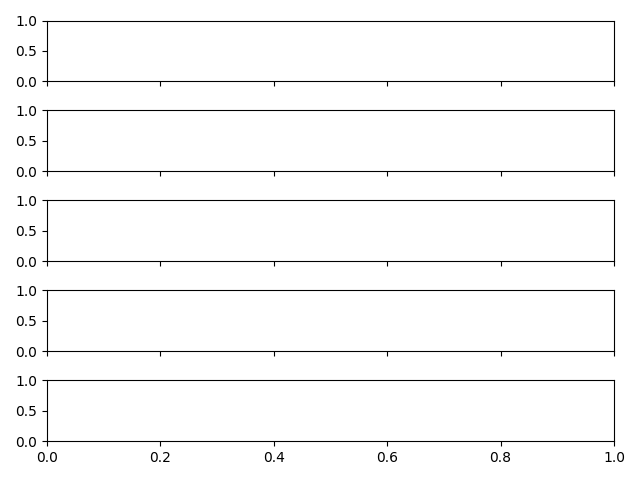

<IPython.core.display.Javascript object>


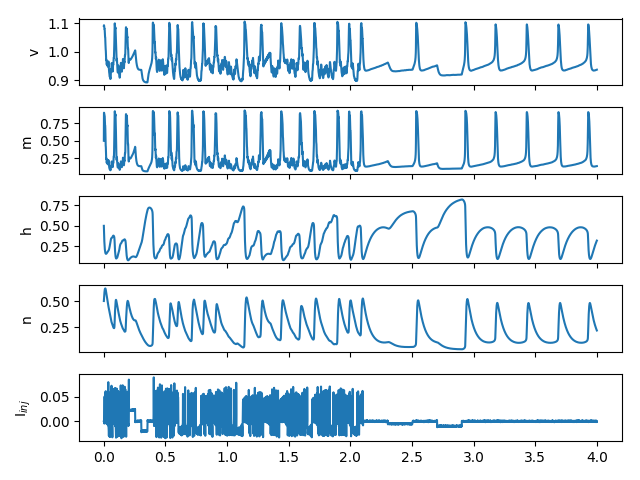

In [18]:
fig, ax = plt.subplots(5,1, sharex=True)
fig.set_tight_layout(True)

ax[0].plot(times_data, data[:,0])
ax[0].set_ylabel('v')

ax[1].plot(times_data, data[:,1])
ax[1].set_ylabel('m')

ax[2].plot(times_data, data[:,2])
ax[2].set_ylabel('h')

ax[3].plot(times_data, data[:,3])
ax[3].set_ylabel('n')

ax[4].plot(times_data, I_inj(times_data))
ax[4].set_ylabel('I$_{inj}$')
plt.show()

Set $\Delta t_f$ based on $\Delta t$.

In [21]:
# model state discretization
freq_mod = 1.0  # how often to put down a state variable
dt_model = dt_data / freq_mod
if freq_mod == 1.0:
    N_model = N_data
else:
    N_model = int(N_data * freq_mod) - 1

#### Initial path/parameter guesses
Later in the notebook, we'll have the option of setting the initial guesses for the observed variables equal to the observations themselves.

In [22]:
# State variables
# This should be an array with N_f elements, where element n_f is a D-dimensional 
# vector. In other words, this is an array of state vectors at all "model times".
X0 = (20.0*np.random.rand(N_model * D) - 10.0).reshape((N_model, D))

n_params = 6
#n_params = 55
# Parameters
Pidx = np.arange(0,n_params)

In [23]:
# Setting ranges for initial guesses
# r controls the size of the search space of the parameters
r = 0.1
Pg = []

# In case we want to estimate a subset of the full parameter set
param_counter = 0

for grp, params in enumerate(model_params):
    for p in params:
        param_counter += 1
        Pg.append([p * (1 - r), p * (1 + r)])
    if param_counter == n_params:
        break

In [24]:
# Compiling initial guesses
Pinit = np.zeros(len(Pidx))

# seed it!
np.random.seed(1)

# Initial guesses
for i, b in enumerate(Pg):
    r = b[1] - b[0]
    Pinit[i] = r*np.random.rand() + b[0]

# cast it as a numpy array
Pinit = np.array(Pinit)

#### Use VA to estimate states and parameters
First we need to initialize an Annealer object, which stores information about the model, data, annealing hyperparameters, and the action.  It also executes the VA algorithm, then is used to save the state and parameter estimates to file.

In [27]:
# Initialize Annealer
anneal1 = va_ode.Annealer()

# Set the model
if n_params == 6:
    anneal1.set_model(neuron, D)
else:
    anneal1.set_model(nakl, D)

# Load the data into the Annealer object
anneal1.set_data(data, t=times_data)

Run VA

In [28]:
# First set some options for the optimization.
# Bounds [v], [m], [h], [n]
bounds = [[0 * V_scale, 1.5 * V_scale], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
for i in xrange(len(Pidx)):
    bounds.append(Pg[i])
    
    
# The full list of options can be found in the scipy.optimization package documentation.
BFGS_options = {'gtol':1.0e-8, 'ftol':1.0e-8, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()  # time how long VA takes

# Annealer.anneal() executes VA for all beta values (defined above)
# Note the init_to_data option: this initializes the measured variables to the data.
anneal1.anneal(X0, Pinit, alpha, beta_array, RM, RF0, Lidx, Pidx, dt_model=dt_model,
               init_to_data=True, disc='SimpsonHermite', method='L-BFGS-B',
               opt_args=BFGS_options, bounds=bounds, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 401
beta = 0, RF = 4.00000000e-06

Taping action evaluation...
Done!
Time = 4.55585598946 s

Beginning optimization...


KeyboardInterrupt: 

# Save action, constituent errors, and state/parameter estimates to file.

In [29]:
anneal1.save_paths("results/paths.npy") #state paths
anneal1.save_params("results/params.npy")
anneal1.save_action_errors("results/action_errors.npy")#saves action and constituent errors

### Plot the results

#### One measured, one unmeasured state variable

In [30]:
# Load path estimates and action curves
allpaths = np.load("results/paths.npy")
aerr = np.load("results/action_errors.npy")
params = np.load("results/params.npy")
# Load the true solution
true_soln = np.load("results/ode_data.npy")

In [31]:
np.around(params[(0,20,40,60,80),:].T, 5)

array([[ 25.85573,   0.     ,   0.     ,   0.     ,   0.     ],
       [  5.49012,   0.     ,   0.     ,   0.     ,   0.     ],
       [  0.44369,   0.     ,   0.     ,   0.     ,   0.     ],
       [  1.06596,   0.     ,   0.     ,   0.     ,   0.     ],
       [  0.8579 ,   0.     ,   0.     ,   0.     ,   0.     ],
       [  0.85458,   0.     ,   0.     ,   0.     ,   0.     ]])

In [32]:
format(params[0,:][0],'f')

'25.855735'

In [33]:
model_params[0:2]

[array([ 26.29206731,   5.25841346,   0.49297626]),
 array([ 1.10983398,  0.92311621,  0.93043848])]

In [34]:
def rmse(x,y, normalize=True): 
    """
    Computes the percent mse of two row vectors
    
    x: vector 1
    y: vector 2
    """
    x, y = (np.array(x), np.array(y))
    error = y - x
    if normalize == True:
        mask = x != 0
        error[:,mask] = np.divide(error[:,mask], x[mask])
    sq_error = np.square(error)
    mean_sq_error = sq_error.mean(axis=1)
    rmsq_error = np.sqrt(mean_sq_error)
    return rmsq_error

def param_error(model_params, params, breakdown=False):
    """
    Used to compute the RMSE of the two inputs.
    
    model_params: list or array of true model parameters
    params: list or array of parameters estimated using varanneal
    """
    #coerce params to np.arrays
    mp = np.array(model_params)
    
    #Thing messes up if you only give it one row, so here's a workaround
    try: 
        if params.shape[1] != 0:
            par = np.array(params)
    except IndexError: 
        par = np.array(params)[None,:]

    #0:3 are the conductances
    #3:6 are the reversal potentials
    #6:13 are the vBias values
    #13:20 are am[] values
    #20:27 are bm[] values
    #27:34 are ah[] values
    #34:41 are bh[] values
    #41:48 are an[] values
    #48:55 are bn[] values
    tot_rmse = []
    tot_rmse.append(rmse(mp[0], par[:,0:3]))
    tot_rmse.append(rmse(mp[1], par[:,3:6]))
    tot_rmse.append(rmse(mp[2], par[:,6:13]))
    tot_rmse.append(rmse(mp[3], par[:,13:20]))
    tot_rmse.append(rmse(mp[4], par[:,20:27]))
    tot_rmse.append(rmse(mp[5], par[:,27:34]))
    tot_rmse.append(rmse(mp[6], par[:,34:41]))
    tot_rmse.append(rmse(mp[7], par[:,41:48]))
    tot_rmse.append(rmse(mp[8], par[:,48:56]))

    tot_rmse = np.array(tot_rmse)
    if breakdown:
        return tot_rmse
    else:
        return tot_rmse.mean(axis=0)


In [35]:
param_error(model_params, params[(0,10,20,30,40),:], breakdown=False)

ValueError: operands could not be broadcast together with shapes (5,0) (7,) 

<IPython.core.display.Javascript object>


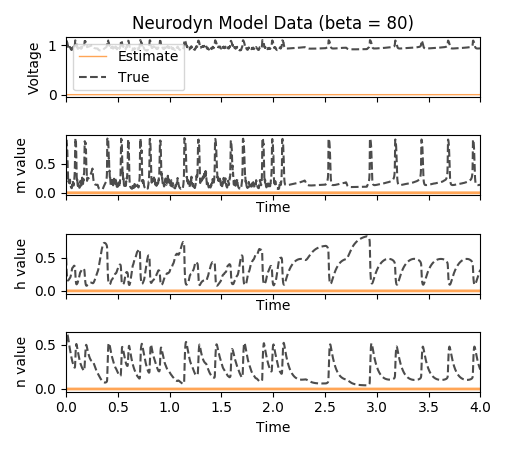

In [36]:
good_beta = [0, 5, 10, 40, 50, 100]
beta_show = 80

plot_idx_meas = 1
plot_idx_unmeas = 2

# plot all path estimates at this beta simultaneously
fig,ax = plt.subplots(4, 1, figsize=(3.375*1.5, 3*1.5), sharex=True)
fig.set_tight_layout(True)
#plt.rc('text', usetex=True)

tplot = allpaths[beta_show, :, 0]

# plot the estimate
ax[0].plot(tplot, allpaths[beta_show, :, plot_idx_meas], color="C1", alpha=0.7, lw=1.0, label="Estimate")
# plot the true solution
ax[0].plot(tplot, true_soln[:, plot_idx_meas], color="black", lw=1.5, ls="--", label="True", alpha=0.7)
ax[0].set_xlim(tplot[0], tplot[-1])
ax[0].set_ylabel(r"Voltage")
ax[0].set_title(r"Neurodyn Model Data (beta = %d)" %beta_show)

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,l)

# plot the estimate
ax[1].plot(tplot, allpaths[beta_show, :, 2], color="C1", alpha=0.7, lw=2.0)
# plot the true solution
ax[1].plot(tplot, true_soln[:, 2], color="black", lw=1.5, ls="--", alpha=0.7)
ax[1].set_xlim(tplot[0], tplot[-1])
ax[1].set_ylabel(r"m value")
ax[1].set_xlabel("Time")

# plot the estimate
ax[2].plot(tplot, allpaths[beta_show, :, 3], color="C1", alpha=0.7, lw=2.0)
# plot the true solution
ax[2].plot(tplot, true_soln[:, 3], color="black", lw=1.5, ls="--", alpha=0.7)
ax[2].set_xlim(tplot[0], tplot[-1])
ax[2].set_ylabel(r"h value")
ax[2].set_xlabel("Time")

# plot the estimate
ax[3].plot(tplot, allpaths[beta_show, :, 4], color="C1", alpha=0.7, lw=2.0)
# plot the true solution
ax[3].plot(tplot, true_soln[:, 4], color="black", lw=1.5, ls="--", alpha=0.7)
ax[3].set_xlim(tplot[0], tplot[-1])
ax[3].set_ylabel(r"n value")
ax[3].set_xlabel("Time")

plt.show()


#### Plot the action

<IPython.core.display.Javascript object>


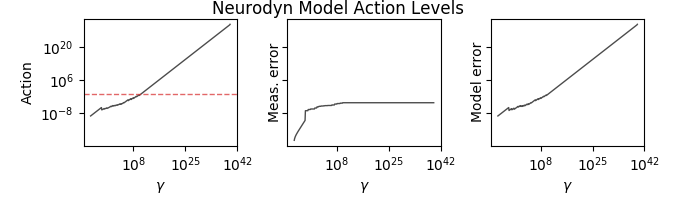

In [29]:
#save_plot_data = False
#save_plot_data_dir = "plot_files/plot_data_action_allterms_L8_onedataset/"

fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$\gamma$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$\gamma$")
ax[2].set_ylabel("Model error")

fig.suptitle("Neurodyn Model Action Levels", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
#    ax[i].set_xlim(1.0e-2, 1.0e7)
#    ax[i].set_ylim(.001, 1.0e2)

plt.show()

---